In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    totalport = np.dot(cur_prices , x_init)+ cash_init
    x_optimal = x_init
    cash_optimal = cash_init
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    #compute the total asset 
    totalport = np.dot(cur_prices , x_init)+ cash_init
    #equally allocate to each stock, which is 1/20 of total asset
    alloctoW = np.ones(20) * totalport * 1/20
    
    
    x_optimal = np.floor(alloctoW/ cur_prices)
    transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
    cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights

In [4]:
def strat_equally_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    totalport = np.dot(cur_prices , x_init)+ cash_init
    #Asset allocation from the first Equally Weighted Algorithm
    x_optimal = np.array([1065,3225,1497,94,2715,993,757,1060,456,307,1469,1800,2771,1369,17748,2414,2465,161,1286,1230])
    transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
    cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & w^TQw \\
{\rm s.t.} & \sum_i w_i = 1\\
& w \geq 0
\end{array}
\end{equation}

In [5]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # compute the total asset 
    totalport = np.dot(cur_prices , x_init)+ cash_init
    # 20 stocks 
    n = 20
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,0.0]])

    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0.0], senses="EG")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)

    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()

    w_minVar = cpx.solution.get_values()[:n]
    alloctoW = np.dot(w_minVar, totalport)
    x_optimal = np.floor(alloctoW/ cur_prices) 
    transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005;
    cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{y,k} & y^TQy \\
{\rm s.t.} &  \sum_i y_i- k = 0\\
& \sum_i (mu_i - r_f)y_i = 1\\
& k \geq 0 \\
& y_i \geq 0
\end{array}
\end{equation}

In [6]:
# def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
#     # compute the total asset 
#     totalport = np.dot(cur_prices , x_init)+ cash_init
#     # 20 stocks + 1 for rate free
#     n = 20
    
#     cpx = cplex.Cplex()
#     cpx.objective.set_sense(cpx.objective.sense.minimize)
#     c  = [0.0] * (n+1)
#     lb = [0.0] * (n+1)
#     ub = [1.0] * (n+1)
    

    
#     r_rf = 0.025;
#     #daily_rf = r_rf/(math.sqrt(252));
#     daily_rf = r_rf/252
#     diff = mu - daily_rf
    
#     A = []
#     for k in range(n):
#         A.append([[0,1],[diff[k],1.0]])
#     A.append([[0,1],[0.0,-1.0]])
    
    
#     cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")
#     var_names = ["w_%s" % i for i in range(1,n+2)]
    

    
#     cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
#     Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
#     Qmat.append([[0],[0.0]])
    
#     cpx.objective.set_quadratic(Qmat)

#     cpx.parameters.threads.set(4)
#     cpx.set_results_stream(None)
#     cpx.set_warning_stream(None)
    
#     cpx.solve()
#     y = cpx.solution.get_values()[:n]
#     k = cpx.solution.get_values()[n:n+1]

#     w _minVar =[x /k[0] for x in y]
#     alloctoW = np.dot(w_minVar, totalport) 
#     x_optimal = np.floor(alloctoW/ cur_prices) 
#     transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005;
#     cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
#     #check if cash_optimal is non negative
#     if cash_optimal < 0:
#         #find out the ratio between the postion of each stock and total position 
#         ratio = (x_optimal / sum(x_optimal))
#         #allocate the negative cash to each stock to balance 
#         cash_balance = np.dot(abs(cash_optimal), ratio)
#         #use the allocated cash divide by stock price to get the position of each stock
#         position_balance = np.ceil(cash_balance / cur_prices)
#         #the new x_optimal is the difference between inital position and balanced position
#         x_optimal = x_optimal - position_balance
#         #recalculated transcation fee
#         transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
#         #recaculate cash_optimal
#         cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
#     weights = (x_optimal*cur_prices)/totalport
#     return x_optimal, cash_optimal, weights

In [7]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    totalport = np.dot(cur_prices , x_init)+ cash_init
    n = 20
    r_rf = 0.025;
    daily_rf = r_rf/252
    diff =np.asmatrix(mu - daily_rf)
    w = cp.Variable(n)
    k = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                     [sum(w)-k == 0,
                      sum((diff)*w) == 1,
                      k >= 0,
                      w >= 0])
    prob.solve(solver=cp.CPLEX, verbose=False,cplex_params={"threads": 4})
    
    w_minVar = w.value/k.value
    alloctoW = np.dot(w_minVar, totalport) 
    x_optimal = np.floor(alloctoW/ cur_prices) 
    transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005;
    cash_optimal = totalport - np.dot(cur_prices, x_optimal)  - transaction
    
    #check if cash_optimal is non negative
    if cash_optimal < 0:
        #find out the ratio between the postion of each stock and total position 
        ratio = (x_optimal / sum(x_optimal))
        #allocate the negative cash to each stock to balance 
        cash_balance = np.dot(abs(cash_optimal), ratio)
        #use the allocated cash divide by stock price to get the position of each stock
        position_balance = np.ceil(cash_balance / cur_prices)
        #the new x_optimal is the difference between inital position and balanced position
        x_optimal = x_optimal - position_balance
        #recalculated transcation fee
        transaction = np.dot(cur_prices, abs((x_optimal - x_init))) * 0.005
        #recaculate cash_optimal
        cash_optimal = totalport - np.dot(cur_prices, x_optimal) - transaction
        
    weights = (x_optimal*cur_prices)/totalport
    return x_optimal, cash_optimal, weights    

In [8]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

In [9]:
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [10]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [11]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

In [12]:
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [13]:
# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [14]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

In [15]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 1000002.12



In [16]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [17]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

In [18]:
# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

In [19]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted','strat_equally_buy_and_hold', 'strat_min_variance','strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio','Equal Weight Buy and Hold', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 4  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_equally_buy_and_hold, strat_min_variance, strat_max_Sharpe]

In [20]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weights = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        # Compute strategy
        
        x[strategy, period-1], cash[strategy, period-1], weights[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
                 portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
        # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)



Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Equal Weight Buy and Hold", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Mininum Variance Portfolio", value begin = $ 991452.06, value end = $ 1016146.40
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.34, value end = $ 1007863.43

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030724.21, value end = $ 1011178.46
  Strategy "Equal Weight Buy and Hold", value begin = $ 1031244.99, value end = $ 1012462.66
  Strategy "Mininum Variance Portfolio", value begin = $ 1023384.69, value end = $ 1014239.69
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1017318.17, value end

In [21]:

# Plot results
###################### Insert your code here ############################

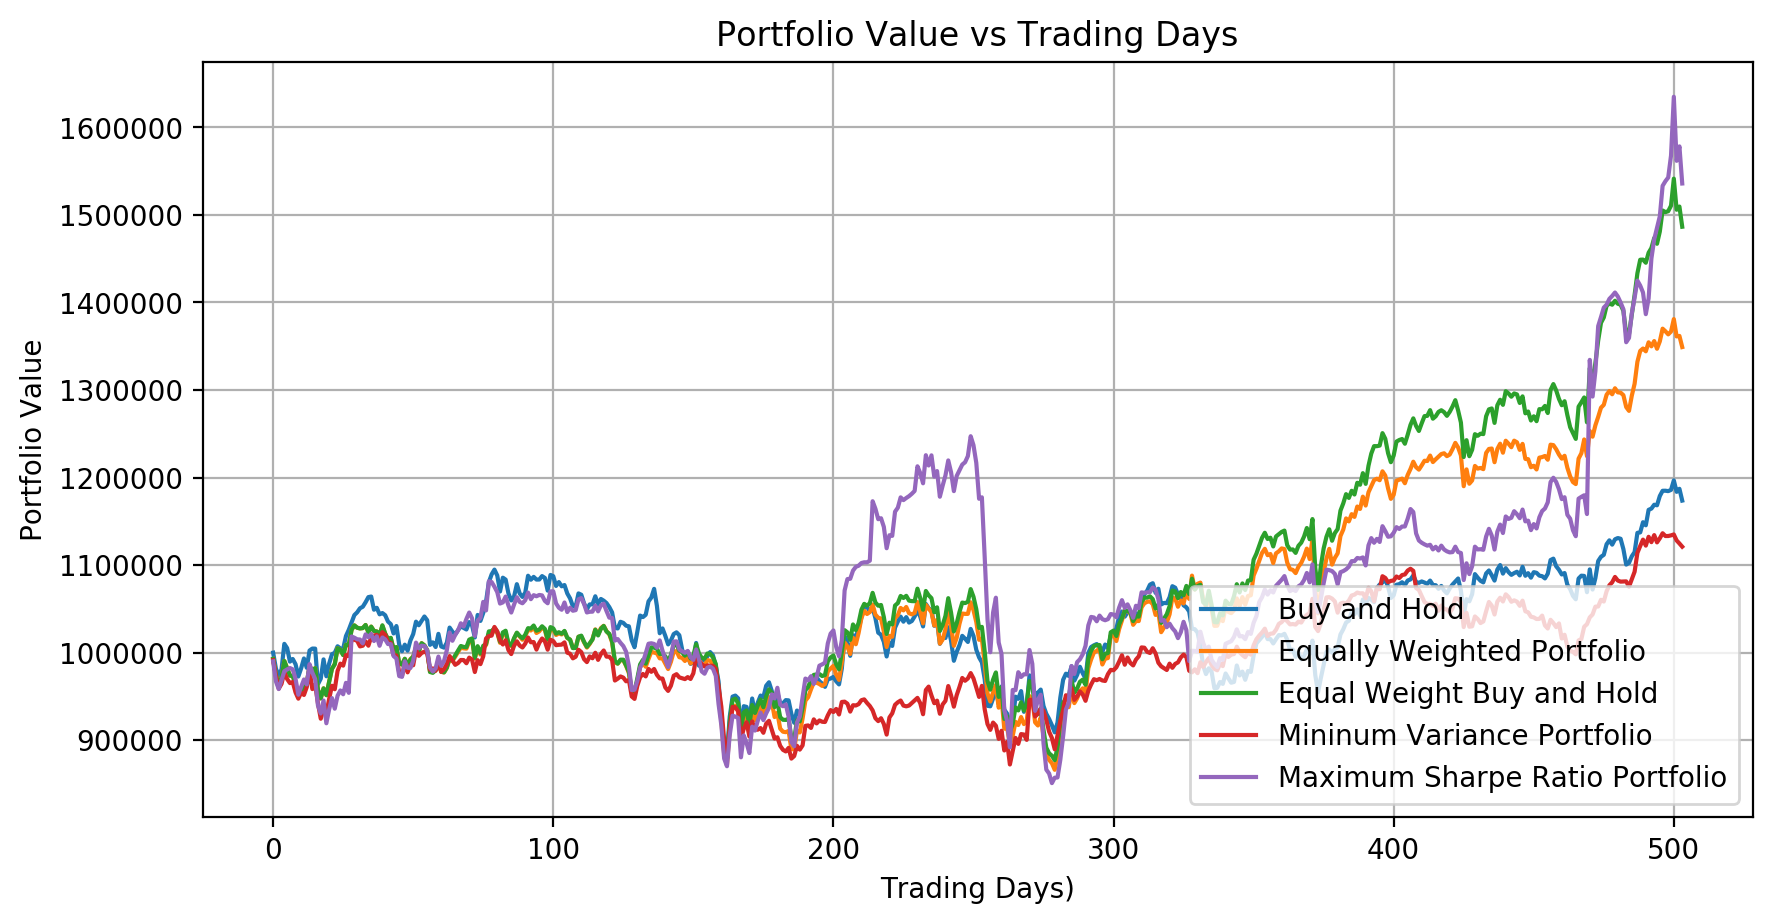

In [31]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 200
for n  in range(N_strat):
    ax2.plot(list(range(len(dates))), portf_value[n], label=strategy_names[n])

ax2.set_xlabel('Trading Days)')
ax2.set_ylabel('Portfolio Value')
plt.title('Portfolio Value vs Trading Days')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()

In [23]:
df_minvarweights = pd.DataFrame()

In [24]:
for i in range(20):
    for j in range(12):
        df_minvarweights = df_minvarweights.append({i: (weights[3][j][i])}, ignore_index = True)

In [25]:
df_minvarweights= df_minvarweights.apply(lambda x: pd.Series(x.dropna().values))
df_minvarweights = df_minvarweights.apply(lambda x: pd.Series(x.dropna().values)).fillna('')

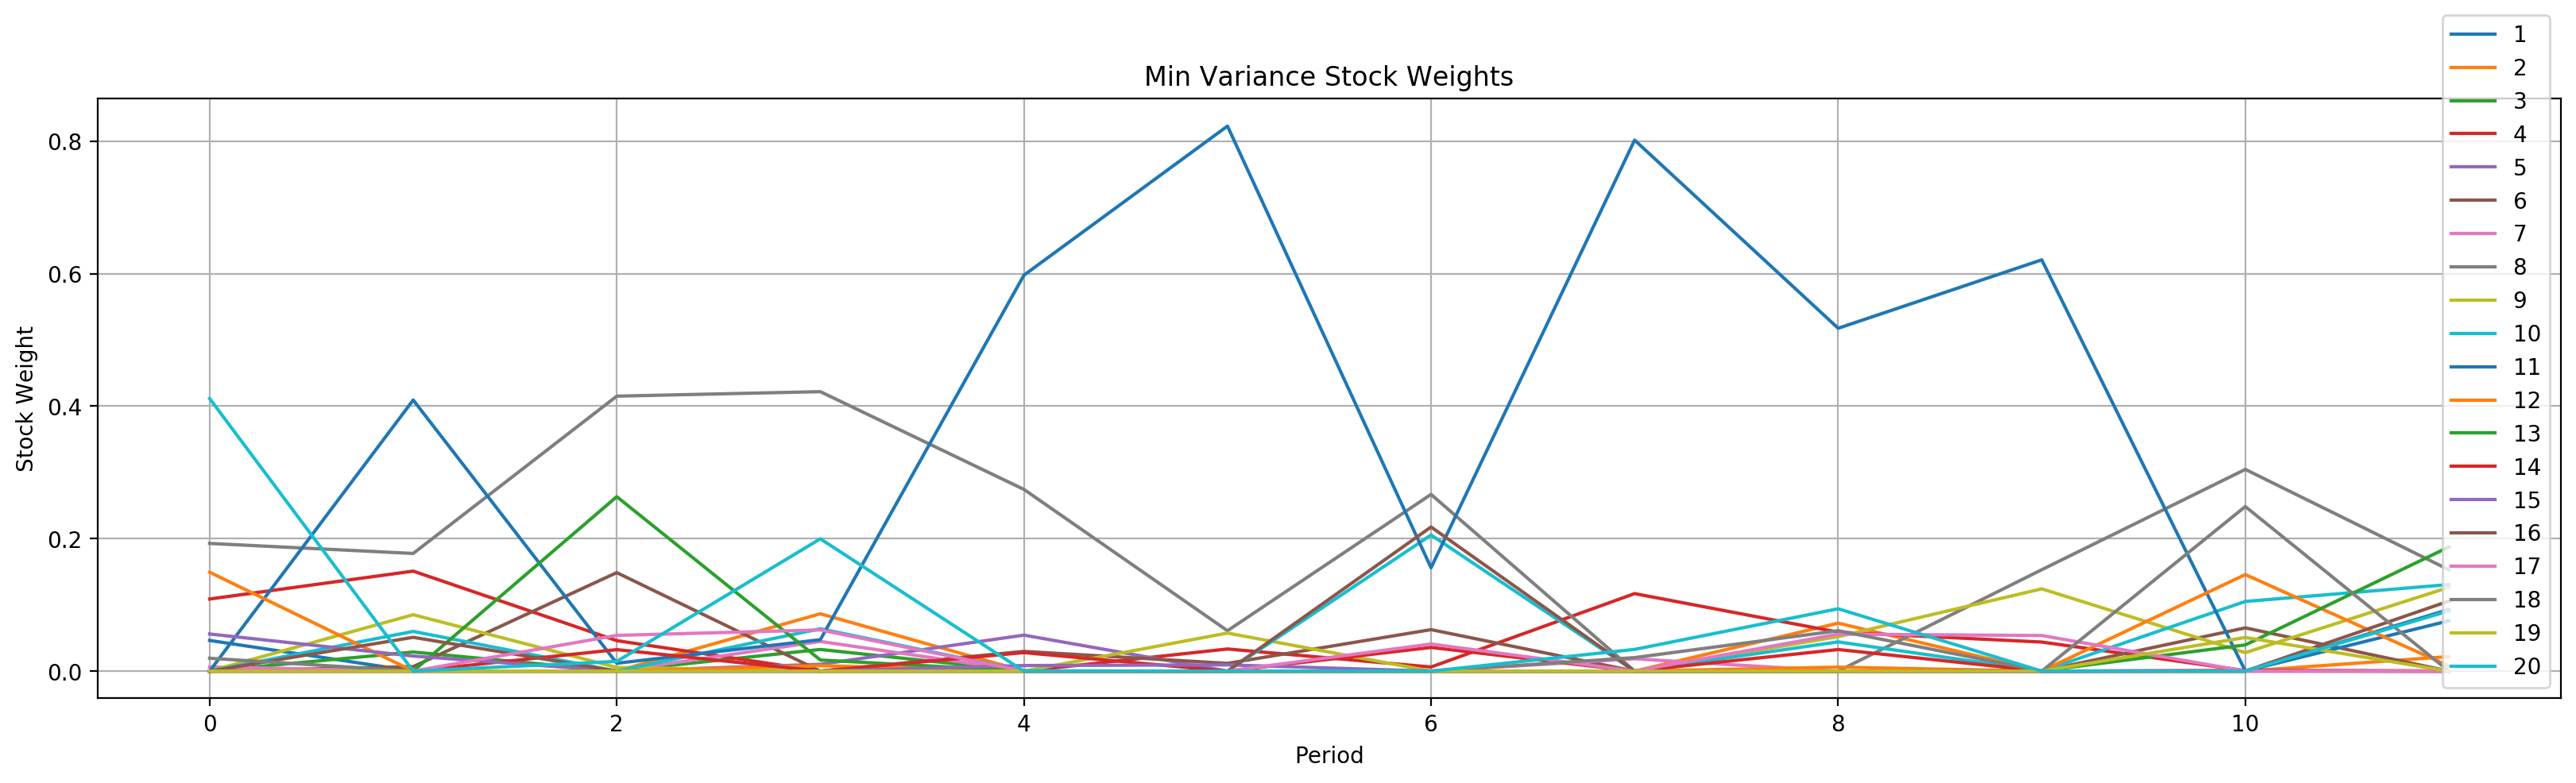

In [26]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200

for i in range(20):   
    ax2.plot(list(range(12)), df_minvarweights[i], label=(i+1),)

ax2.set_xlabel('Period')
ax2.set_ylabel('Stock Weight')
plt.title('Min Variance Stock Weights')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()

In [27]:
df_maxsharweights = pd.DataFrame()

In [28]:
for i in range(20):
    for j in range(12):
        df_maxsharweights = df_maxsharweights.append({i: (weights[4][j][i])}, ignore_index = True)

In [29]:
df_maxsharweights= df_maxsharweights.apply(lambda x: pd.Series(x.dropna().values))
df_maxsharweights = df_maxsharweights.apply(lambda x: pd.Series(x.dropna().values)).fillna('')

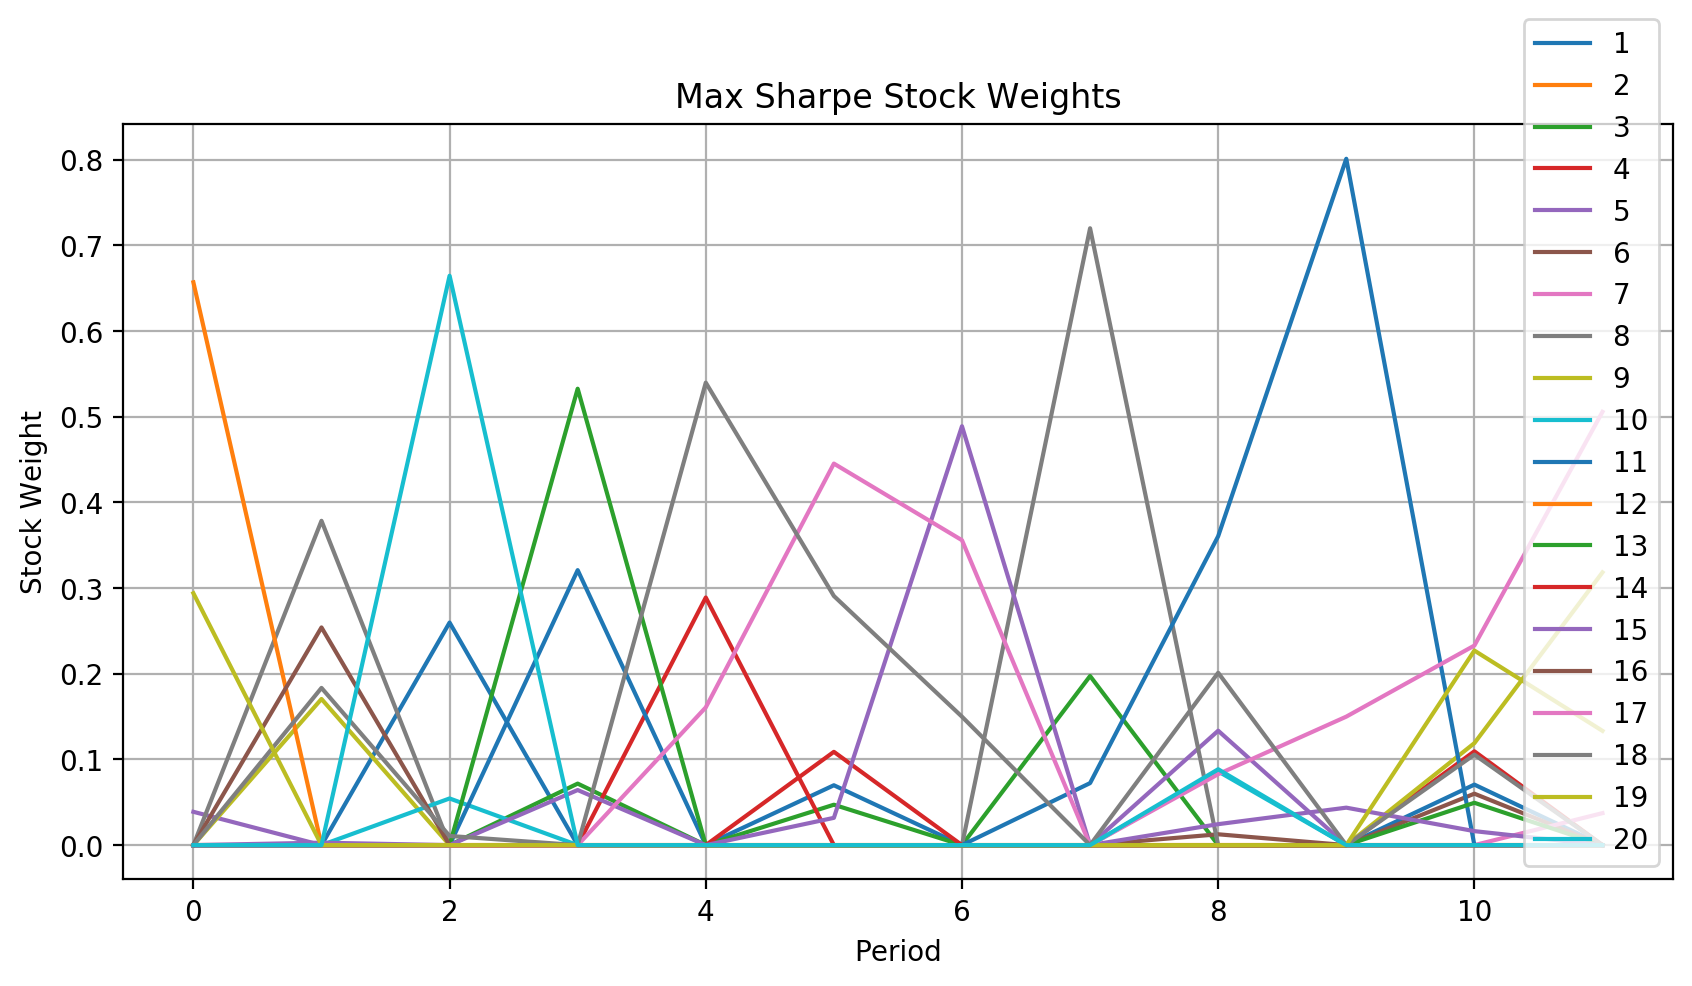

In [30]:
ax2 = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200

for i in range(20):   
    ax2.plot(list(range(12)), df_maxsharweights[i], label=(i+1),)

ax2.set_xlabel('Period')
ax2.set_ylabel('Stock Weight')
plt.title('Max Sharpe Stock Weights')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()